### Monte Carlo forecasting of the 2016 US presidential election 



I've used the latest state-by-state poll results <a href="http://projects.fivethirtyeight.com/general-model/president_general_polls_2016.csv">downloaded</a> on Nov 7, 2016, from the <a href="http://projects.fivethirtyeight.com/2016-election-forecast/">538</a> website. The data contains poll results by state and by date, with each poll assigned a weight by 538. These weights are used to compute parameters of the poll distribution: the weighted mean and standard deviation and filter out polls with zero or low weights. 

In addition, polls and actual results from 2008 and 2012 elections are used to estimate possible poll biases for each state and party and covariance in poll fluctuations across the state. The bias and covariance matrix (and corresponding correlation matrix) are estimated in routine <tt>compute_state_covariance_matrix</tt>. The actual Monte Carlo simulations of elections are carried out by routine <tt>simulate_elections</tt> with the input poll_data, covariance matrices, poll weight threshold, etc. The plotting and stat. analysis routines are at the bottom, their cells should be run first before the first use.

Below I provide a summary of results of 5 variants of the model with different assumptions.

* Model 1. The simplest model. Poll results are realized by drawing Monte Carlo realizations of random numbers from the <a href="https://en.wikipedia.org/wiki/Student%27s_t-distribution">Student's t-distribution</a>. Namely, for each state the weighted average and standard deviation of $N$ poll results is estimated. Random numbers, $t$, drawn from the t-distribution with $N-1$ degrees of freedom, then give distribution of actual vote fractions for each candidate: $v = \bar{p} - ts$, where 
$$\bar{p}=\frac{\sum_i^{N_{\rm polls}} p_i w_i}{\sum_i^{N_{\rm polls}} w_i},$$
is the weighted average of the $N_{\rm polls}$ poll results for the state and $s$ is the weighted standard deviation. 

* Model 2. Correlations, no bias. Correlation matrix is estimated from the poll results in 2008 and 2012 elections and is applied to produce correlated random numbers $t$ using Cholesky decomposition. 

* Model 3. Correlations, bias. State-by-state bias is estimated from the difference between the actual election results and poll predictions in 2008 and 2012 elections, separately for two parties. The bias is applied to random draws done as in model 2. 

* Model 4. The same as model 3, but with bias with reversed sign. This is definitely arbitrary, but is a model of the case where biases have magnitude comparable to previous elections (and comparable to the bias found during recent Brexit vote), but which are in the opposite directions. 

* Model 5. The same as model 2 (no bias), but using covariance matrix estimated from variation of poll residuals in 2008 and 2012 elections instead of the current estimate of poll variation.

We use t-distribution here because  distribution of poll results in a sample of $N_{\rm polls}$ follows t-distribution with the mean and rms of the sample, if the underlying distribution of poll results is Gaussian. The model thus assumes that poll results are distributed as a Gaussian. Reasonable assumption, but needs to be checked and likely true only for polls within a limited time interval.

<b>Summary of model results.</b> I will consider model 2 to be "fiducial" somewhat arbitrarily. It is definitely more sophisticated than model 1 and results are qualitatively similar to model 5. However, it applies no bias. The difference between models 3 and 4 gives us the sense of systematic uncertainty due the poll biases. 
Thus, model 2 can be viewed as a baseline, while models 3 and 4 as extremes of the expected distribution of outcomes.

The variation in the election results caused by $\approx 5\%$ bias is much larger than any other uncertainty in the models and shows that unexpected poll biases in key states can lead to results that completely defy expectations: from a landslide for Clinton (model 3) to a toss up with high probability of Trump winning (model 4). One could argue against particular choices of bias, but is certain that biases of $\approx 5\%$ exist in poll results in previous elections (see printed Table of biases, defined as the average difference of results and poll predictions for each state and party below). Poll bias of similar magnitude was reported during recent "Brexit" vote. Thus, one has to admit the possibility of such biases and their potentially large effect on the outcome.

Overall, Trump has a low probability of winning unless the poll biases are of the magnitude observed in 2008 and 2012 elections for Dem. party, but now for Rep. party. 

<b>Comparison with 538 predictions.</b> The distribution of electoral votes closest to <a href="http://projects.fivethirtyeight.com/2016-election-forecast/?ex_cid=rrpromo#electoral-vote">538 predictions</a> is given by models 2 and 5. However, 538's distribution has wider tails and none of the models explored match these. This is most likely due to their use of poll correlation matrix based on much longer election record. The difference in tails also explains the much higher probability of Trump win estimated by 538. Given the possible effects of unknown poll bias, the difference between model predictions shown here and 538's are within the uncertainty due to the poll biases.

<b>Model results</b> Below I present results of each model with basic statistics, electoral vote distribution, and vote percentages per state. The electoral vote distribution is plotted using the <a href="http://www.astroml.org/examples/algorithms/plot_bayesian_blocks.html">"Bayesian blocks"</a> binning because distributions contain both random (Poisson) noise and structure due to large jumps to electoral vote counts due to certain states. Bayesian blocks binning shows real structure, while suppressing the noise. 

<b>Electoral vote counts vs popular vote.</b> Below is a plot of the number of electoral votes as a function of fraction of popular vote won by Clinton and Trump in model elections in model 2. The correlation between total electoral votes and popular vote for each candidate is weak (almost no correlation for Trump). It is possible to win election ($N_{\rm electoral}>270$), while losing popular vote, depending on how the electoral votes stack up in different states. Most Trump wins in model 2 would have to be of this kind. Such outcomes are not rare, as 2000 election shows. 

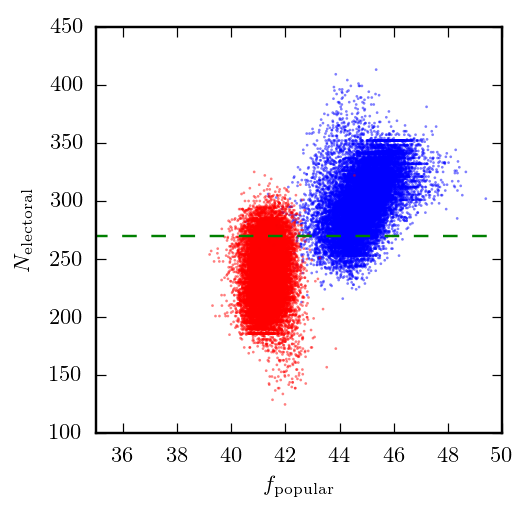

In [249]:
plot_Nelectoral_vs_popular_vote(r'model 2 (corr. model)', 
                                corr_model_results, states_electoral)

In [103]:
import numpy as np
from codes.setup import data_home_dir
import pandas 
from codes.plot_utils import plot_pretty

plot_pretty()
# read poll data and electoral votes assigned to each state
poll_data = pandas.read_csv(data_home_dir()+'president_general_polls_2016.csv')
states_electoral = pandas.read_csv(data_home_dir()+'states_electoral.csv')

In [105]:
from sklearn.covariance import shrunk_covariance, ledoit_wolf, oas

def compute_state_covariance_matrix(states_electoral):
    """
    compute bias vectors and covariance matrix using 2008 and 2012 election results 
    """
    states      = states_electoral['State']
    state_names = states_electoral['Name']
    nstates     = states.size

    dem_results = np.zeros(nstates); rep_results = np.zeros(nstates);
    dem_polls = np.zeros((nstates,2)); rep_polls = np.zeros((nstates,2));
    for i, yr in enumerate([2008, 2012]):
        # the lines below show you how to read and extract poll and election results of 2008 and 2012 Presidential elections
        prev_election_results = pandas.read_csv(data_home_dir()+str(yr)+'-results.csv')
        dem_results += np.array(prev_election_results['Dem'])
        rep_results += np.array(prev_election_results['Rep'])
        prev_poll_results = pandas.read_csv(data_home_dir()+str(yr)+'-polls.csv')
        # average out poll results for each state
        for ist, st in enumerate(states):
            stpolls = prev_poll_results[prev_poll_results['State'] == st]
            dem_polls[ist,i] = np.mean(np.array(stpolls['Dem']))
            rep_polls[ist,i] = np.mean(np.array(stpolls['Rep']))
    
    dem_results *= 0.5; rep_results *= 0.5
    dem_polls_ave = 0.5*(dem_polls[:,0] + dem_polls[:,1])
    rep_polls_ave = 0.5*(rep_polls[:,0] + rep_polls[:,1])
    bias_dem = dem_results - dem_polls_ave
    bias_rep = rep_results - rep_polls_ave
    dem_polls[:,0] -= dem_polls_ave; dem_polls[:,1] -= dem_polls_ave
    rep_polls[:,0] -= rep_polls_ave; rep_polls[:,1] -= rep_polls_ave
    cov_dem = np.cov(dem_polls); cov_rep = np.cov(rep_polls)
    
    # regularize empirical covariance matrix estimate
    #cov_dem, shr_dem = ledoit_wolf(cov_dem)
    #cov_rep, shr_rep = ledoit_wolf(cov_rep)
    cov_dem, shr_dem = oas(cov_dem)
    cov_rep, shr_rep = oas(cov_rep)
    corr_dem, corr_rep = np.zeros_like(cov_dem), np.zeros_like(cov_dem)
    for i in range(nstates):
        for j in range(nstates):
            corr_dem[i,j] = cov_dem[i,j] / np.sqrt(cov_dem[i,i] * cov_dem[j,j])
            corr_rep[i,j] = cov_rep[i,j] / np.sqrt(cov_rep[i,i] * cov_rep[j,j])
    
    # make sure that matrices are positive definite
    if not np.all(np.linalg.eigvals(cov_dem) > 0):
        raise Exception("cov_dem is not positive definite, try increasing shrinkage parameter")
    if not np.all(np.linalg.eigvals(cov_rep) > 0):
        raise Exception("cov_rep is not positive definite, try increasing shrinkage parameter")
    if not np.all(np.linalg.eigvals(corr_dem) > 0):
        raise Exception("corr_dem is not positive definite, try increasing shrinkage parameter")
    if not np.all(np.linalg.eigvals(corr_rep) > 0):
        raise Exception("corr_rep is not positive definite, try increasing shrinkage parameter")
        
    return bias_dem, cov_dem, corr_dem, bias_rep, cov_rep, corr_rep

In [106]:
bias_dem, cov_dem, corr_dem, bias_rep, cov_rep, corr_rep = compute_state_covariance_matrix(states_electoral)

def print_matrix(a):
    print "Matrix["+("%d" %a.shape[0])+"]["+("%d" %a.shape[1])+"]"
    rows = a.shape[0]; cols = a.shape[1]
    for i in range(0, rows):
        for j in range(0, cols):
            print("%5.2f" %a[i,j]),
    print    

#print print_matrix(cov_dem)
#print print_matrix(cov_dem_my)

Ldem = np.linalg.cholesky(cov_dem)
Lrep = np.linalg.cholesky(cov_rep)

In [228]:
from numpy.random import standard_t as tdist

def std_weighted(values, average, weights):
    # implementing unbiased weighted std formula derived here:
    # http://mathoverflow.net/questions/11803/unbiased-estimate-of-the-variance-of-a-weighted-mean
    variance = np.average((values-average)**2, weights=weights)/(1.0 - np.sum(weights**2)) 
    return np.sqrt(variance)

def simulate_elections(poll_data, states_electoral, date_range, poll_type = 'rawpoll', min_weight = 0.01, 
                       correlations = False, nsims = 10, **kwargs):
    """
    input: poll_date = csv table from 538
           states_electoral = list of states in the same alphabetical order as in the 538 table with electoral counts for each state
           date_range = use only polls with start date within this range of dates; 
                        e.g., date_range = ['10-20-2016', '11-04-2016']
           poll_type = 'rawpoll' or 'adjpoll' - raw or adjusted polls to use from 538 table
           min_weight = only use polls with the assigned weights larger or equal to this minimum
           correlations = if True use covariance or correlation matrices for republicans and democrates that are
                           expected in kwargs array as cov_rep and cov_dem, as well as biases bias_rep and bias_dem
           nsims = # of random election realizations to run
           kwargs = array containing auxiliary information, such as cov_dem, cov_rep, bias_dem, bias_rep
    """
    states = states_electoral['State']
    state_names = states_electoral['Name']
    electors = states_electoral['Electors']
    nstates = states.size

    dates = pandas.to_datetime(poll_data['startdate'])

    ave_clinton, std_clinton, n_clinton = np.zeros(nstates), np.zeros(nstates), np.zeros(nstates, dtype=np.int); 
    ave_trump,   std_trump,   n_trump   = np.zeros(nstates), np.zeros(nstates), np.zeros(nstates, dtype=np.int); 
    ave_johnson, std_johnson, n_johnson = np.zeros(nstates), np.zeros(nstates), np.zeros(nstates, dtype=np.int);
    clinton_vote_dist = np.zeros((nstates,nsims))
    trump_vote_dist   = np.zeros((nstates,nsims))
    johnson_vote_dist = np.zeros((nstates,nsims))
    clinton_electoral_votes = np.zeros(nsims)
    trump_electoral_votes   = np.zeros(nsims)
    johnson_electoral_votes = np.zeros(nsims)
    
    if correlations:
        bias_dem = kwargs["bias_dem"]; bias_rep = kwargs["bias_rep"]
        cov_dem = kwargs["cov_dem"];   cov_rep = kwargs["cov_rep"]
        Ldem = np.linalg.cholesky(cov_dem); Lrep = np.linalg.cholesky(cov_rep)
        
    ndraws = 0 
    for i, state in enumerate(state_names):
        poll_state = poll_data[(poll_data['poll_wt'] >= min_weight) & (poll_data['state'] == state) & 
                               (dates > date_range[0]) & (dates < date_range[1])]
        poll_weights = poll_state['poll_wt'] 
        poll_weights /= np.sum(poll_weights)
        trump_polls   = poll_state[poll_type+'_trump']
        clinton_polls = poll_state[poll_type+'_clinton']
        johnson_polls = np.nan_to_num(poll_state[poll_type+'_johnson'])

        #ave_clinton[i], std_clinton[i],  n_clinton[i] = np.average(clinton_polls, weights=poll_weights), np.std(clinton_polls, ddof=1), clinton_polls.size 
        #ave_trump[i],   std_trump[i],   n_trump[i]   = np.average(trump_polls, weights=poll_weights),   np.std(trump_polls, ddof=1),   trump_polls.size 
        #ave_johnson[i], std_johnson[i], n_johnson[i] = np.average(johnson_polls, weights=poll_weights), np.std(johnson_polls, ddof=1), johnson_polls.size 

        ave_clinton[i], n_clinton[i] = np.average(clinton_polls, weights=poll_weights), clinton_polls.size 
        std_clinton[i]               = std_weighted(clinton_polls, ave_clinton[i], poll_weights)
        ave_trump[i],   n_trump[i]   = np.average(trump_polls, weights=poll_weights),   trump_polls.size 
        std_trump[i]                 = std_weighted(trump_polls, ave_trump[i], poll_weights)
        ave_johnson[i], n_johnson[i] = np.average(johnson_polls, weights=poll_weights), johnson_polls.size 
        std_johnson[i]               = std_weighted(johnson_polls, ave_johnson[i], poll_weights)

        johnson_votes = ave_johnson[i] - std_johnson[i] * tdist(n_johnson[i]-1, size=nsims)
        johnson_vote_dist[i,:] = johnson_votes 

        if not correlations: 
            clinton_votes = ave_clinton[i] - std_clinton[i] * tdist(n_clinton[i]-1, size=nsims)
            trump_votes   = ave_trump[i]   - std_trump[i]   * tdist(n_trump[i]-1,   size=nsims)
            draws = (johnson_votes == trump_votes) | (johnson_votes == clinton_votes) | (trump_votes == clinton_votes)
            clinton_wins = (clinton_votes[:] > trump_votes[:])    & (clinton_votes[:] > johnson_votes[:])
            trump_wins   = (trump_votes[:]   > clinton_votes[:])  & (trump_votes[:]   > johnson_votes[:])
            johnson_wins = (johnson_votes[:] > clinton_votes[:])  & (johnson_votes[:] > trump_votes[:])
            clinton_electoral_votes[clinton_wins] += electors[i]
            clinton_electoral_votes[draws]        += electors[i] # assume all draws go to Clinton
            trump_electoral_votes[trump_wins]     += electors[i]
            johnson_electoral_votes[johnson_wins] += electors[i]
            #print i, state, clinton_electoral_votes, trump_electoral_votes, clinton_votes, trump_votes, ave_johnson[i], clinton_wins, johnson_wins
            ndraws += len(clinton_electoral_votes[draws])
            clinton_vote_dist[i,:] = clinton_votes
            trump_vote_dist[i,:]   = trump_votes

        else:
            clinton_vote_dist[i,:] = tdist(n_clinton[i]-1, size=nsims)
            trump_vote_dist[i,:] = tdist(n_trump[i]-1, size=nsims)
            # no correlation data for 3rd party, so leave as is

    if correlations:
        if np.max(cov_dem) == 1.0: # if input matrix is correlation matrix
            for i in range(nsims):
                clinton_vote_dist[:,i] = ave_clinton  - std_clinton*np.dot(Ldem,  clinton_vote_dist[:,i]) + bias_dem
                trump_vote_dist[:,i]   = ave_trump    - std_trump*np.dot(Lrep,  trump_vote_dist[:,i]) + bias_rep
        else: # if input matrix is covariance matrix
            for i in range(nsims):
                clinton_vote_dist[:,i] = ave_clinton  - np.dot(Ldem,  clinton_vote_dist[:,i]) + bias_dem
                trump_vote_dist[:,i]   = ave_trump    - np.dot(Lrep,  trump_vote_dist[:,i]) + bias_rep
            
        for i in range(nstates):
            johnson_votes = ave_johnson[i] - std_johnson[i] * tdist(n_johnson[i]-1, size=nsims)
            clinton_votes, trump_votes = clinton_vote_dist[i,:], trump_vote_dist[i,:]
            draws = (johnson_votes == trump_votes) | (johnson_votes == clinton_votes) | (trump_votes == clinton_votes)
        
            clinton_electoral_votes[(clinton_votes[:]>trump_votes[:]) & (clinton_votes[:]>johnson_votes[:])] += electors[i]
            clinton_electoral_votes[draws] += electors[i] # assume all draws go to Clinton
            trump_electoral_votes[(trump_votes[:]>clinton_votes[:]) & (trump_votes[:]>johnson_votes[:])]     += electors[i]
            johnson_electoral_votes[(johnson_votes[:]>clinton_votes[:]) & (johnson_votes[:]>trump_votes[:])] += electors[i]
        
            ndraws += len(clinton_electoral_votes[draws])

    return clinton_electoral_votes, trump_electoral_votes, johnson_electoral_votes, clinton_vote_dist, trump_vote_dist, johnson_vote_dist
        

#### Simplest model

First, predictions of the simplest model where state polls are assumed to be independent and unbiased. 

Results below indicate that state-by-state predictions of Clinton/Trump win probabilities of this model are closest to the corresponding <a href="http://projects.fivethirtyeight.com/2016-election-forecast/">state-by-state predictions</a> of the 538 website among the considered models. Notable discrepancies of the simple model with 538 predictions are Florida (52% for Trump), North Carolina (52% for Trump), as of Nov 5, 2016.

The good agreement of the simple model with 538 predictions for individual states suggests that the latter do not account for covariances between poll errors and biases in computing probabilities of the outcome. This means that their probabilities are too "polarized" and results for quite a few states for which they predict low probability for one of the candidates have a good chance to actually go to the other candidate, if the neglected covariances and biases are strong.  

In [229]:
poll_type = 'rawpoll'
date_range = ['10-20-2016', '11-07-2016']
nsims = 20000
kwargs = {}

simplest_model_results = simulate_elections(poll_data, states_electoral, date_range, poll_type, min_weight = 0.5, nsims = nsims, **kwargs)

clinton_electoral_votes, trump_electoral_votes, johnson_electoral_votes = model_results[0], model_results[1], model_results[2]
clinton_vote_dist, trump_vote_dist, johnson_vote_dist = model_results[3], model_results[4], model_results[5]

In [230]:
model_name = r'model 1 (simplest model)'
election_stats(model_name, simplest_model_results)

================= Results of election simulations in the  model 1 (simplest model) ===
Clinton wins in 90.2 per cent of elections
        average and median Nelectoral = 302.00 and 303.00; in 95 percent range = [253.98  348.00]
Trump   wins in 9.0 per cent of elections
        average and median Nelectoral = 236.00 and 235.00; in 95 percent range = [190.00  284.02]
Johnson wins in 0.0 per cent of elections
        average and median Nelectoral = 0.00 and 0.00; in 95 percent range = [0.00  0.00]


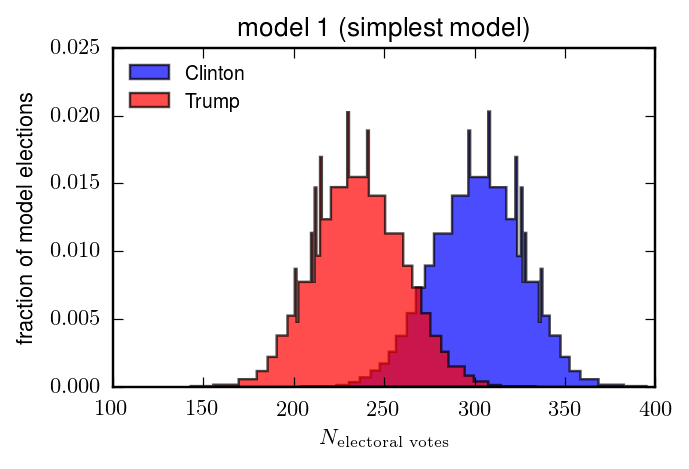

In [231]:
plot_electoral_vote_distribution(model_name, simplest_model_results, htype='bayesian_blocks')

============ State-by-state vote predictions for model 1 (simplest model) ==============
               State   Clinton win prob.  Trump win prob.   Johnson win prob.
 
              Alaska        0.283           0.717              0.000
             Alabama        0.011           0.989              0.000
            Arkansas        0.000           1.000              0.000
             Arizona        0.282           0.718              0.000
          California        1.000           0.000              0.000
            Colorado        0.826           0.174              0.000
         Connecticut        0.945           0.055              0.000
District of Columbia        1.000           0.000              0.000
            Delaware        0.932           0.068              0.000
             Florida        0.586           0.414              0.000
             Georgia        0.103           0.897              0.000
              Hawaii        1.000           0.000              0.000
   

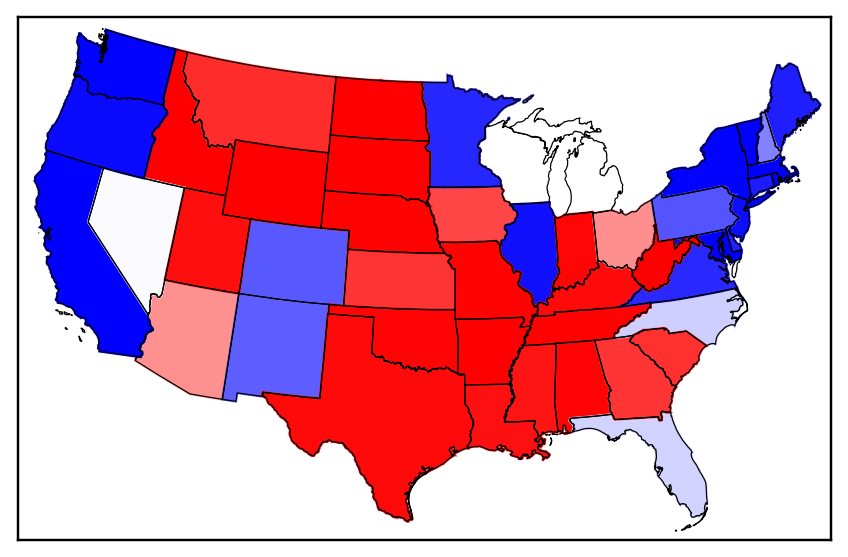

In [220]:
plot_map(model_name, simplest_model_results)

#### Model with poll covariances, but no poll bias

Now predictions of the model, in which estimate of covariance of poll results between states is taken into account when generating model realizations of state by state elections. Polls still are considered to be unbiased here.

The application of covariances make predictions for individual states much less polarized. For example, Trump's probability of winning Alaska decreases from 66% to 51%, in Arkansas probability of Clinton win increases from 1% to 40%, in Illinois Trump's win probability increases from ~1% to 33%, etc. This is because, in our estimate of covariance based on polls in 2008 and 2012 elections, the variance of polls election to election was considerably larger than the variance of polls for a single election. This variance, as well as covariance between states, which is generally larger than the variance within state, broad distribution of election outcomes in each states thereby predicting less polarized win probabilities for Clinton and Trump. 

Below is a visualization of our estimate of the covariance matrix of polls. We can see that 1) cross-state covariance is generally larger than state variance and 2) generally, the variance for one state is not much larger than covariance between states, except for a few states, 3) covariance for democrats is considerably larger than for republicans.

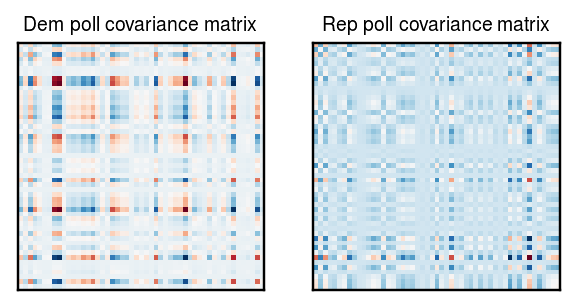

In [113]:
from matplotlib import pylab as plt
_, ax = plt.subplots(1, 2, figsize=(4.,8.))
ax[0].imshow(cov_dem, interpolation='nearest', #vmin=-vmax, vmax=vmax,
               cmap=plt.cm.RdBu_r)
ax[0].set_xticks(())
ax[0].set_yticks(())
ax[0].set_title('Dem poll covariance matrix', fontsize=8)

ax[1].imshow(cov_rep, interpolation='nearest', #vmin=-vmax, vmax=vmax,
               cmap=plt.cm.RdBu_r)
ax[1].set_xticks(())
ax[1].set_yticks(())
ax[1].set_title('Rep poll covariance matrix', fontsize=8)

plt.show()

In [232]:
nsims = 20000

bias_zero = np.zeros_like(bias_dem)
kwargs = {"bias_dem": bias_zero, "cov_dem": corr_dem, "bias_rep": bias_zero, "cov_rep": corr_rep}

corr_model_results = simulate_elections(poll_data, states_electoral, date_range, poll_type, 
                                   min_weight = 0.5, correlations = True, nsims = nsims, **kwargs)

In [233]:
model_name = r'model 2 (correlations, no bias)'
election_stats(model_name, corr_model_results)

================= Results of election simulations in the  model 2 (correlations, no bias) ===
Clinton wins in 87.9 per cent of elections
        average and median Nelectoral = 302.19 and 303.00; in 95 percent range = [253.00  352.00]
Trump   wins in 11.0 per cent of elections
        average and median Nelectoral = 235.81 and 235.00; in 95 percent range = [186.00  285.00]
Johnson wins in 0.0 per cent of elections
        average and median Nelectoral = 0.00 and 0.00; in 95 percent range = [0.00  0.00]


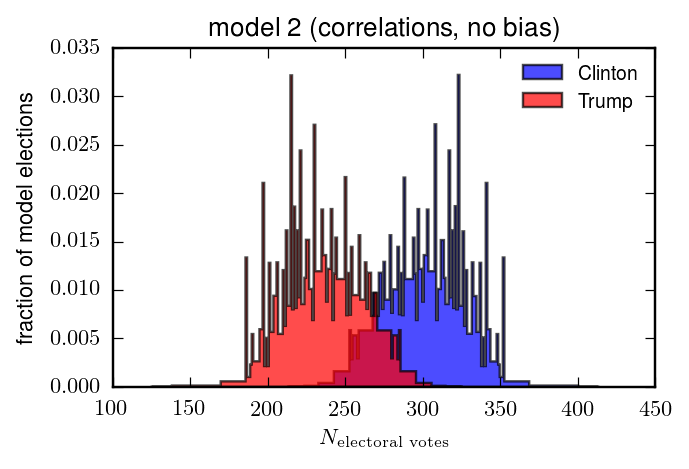

In [234]:
plot_electoral_vote_distribution(model_name, corr_model_results, htype='bayesian_blocks')

============ State-by-state vote predictions for model 2 (correlations, no bias) ==============
               State   Clinton win prob.  Trump win prob.   Johnson win prob.
 
              Alaska        0.282           0.718              0.000
             Alabama        0.010           0.990              0.000
            Arkansas        0.000           1.000              0.000
             Arizona        0.296           0.704              0.000
          California        1.000           0.000              0.000
            Colorado        0.812           0.188              0.000
         Connecticut        0.942           0.058              0.000
District of Columbia        1.000           0.000              0.000
            Delaware        0.945           0.055              0.000
             Florida        0.585           0.415              0.000
             Georgia        0.117           0.883              0.000
              Hawaii        1.000           0.000              0.

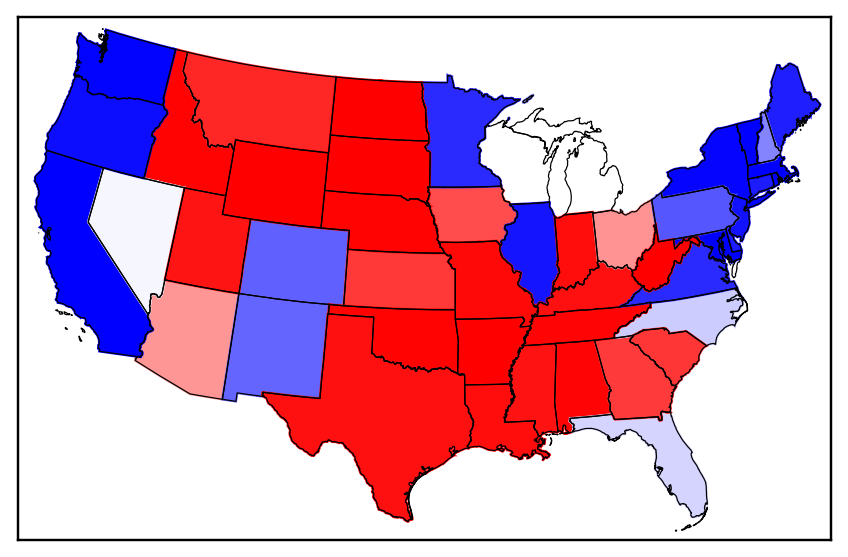

In [235]:
plot_map(model_name, corr_model_results)

#### Model 3 with covariances and poll bias estimated from results and polls of 2008 and 2012 elections

This is the full model. Biases change results significantly for some states: e.g., Nevada, Florida etc. It's not clear whether this estimate of the bias is reasonable. The bias in 2008 and 2012 can be different in those elections (which involved african american candidate) and in this election (involving a female candidate), but there are reasons to think that they may be similar. 

The estimated bias apparently favors democrates as it increases the probabilities of Clinton win in many states (e.g., by 20% in Michigan). This is because many of the polls in 2008 and 2012 have overestimated percentages of votes that republicans would get. This is reflected in the measured bias: when it is applied it decreases poll percentages for Trump relative to Clinton, thereby greatly decreasing the overall probability of Trump win.

In [236]:
nsims = 20000

#bias_zero = np.zeros_like(bias_dem)
kwargs = {"bias_dem": bias_dem, "cov_dem": corr_dem, "bias_rep": bias_rep, "cov_rep": corr_rep}

corr_bias_model_results = simulate_elections(poll_data, states_electoral, date_range, poll_type, 
                                   min_weight = 0.5, correlations = True, nsims = nsims, **kwargs)

In [237]:
model_name = r'model 3 (correlations, + bias)'
election_stats(model_name, corr_bias_model_results)

================= Results of election simulations in the  model 3 (correlations, + bias) ===
Clinton wins in 99.3 per cent of elections
        average and median Nelectoral = 323.46 and 323.00; in 95 percent range = [279.00  358.00]
Trump   wins in 0.5 per cent of elections
        average and median Nelectoral = 214.54 and 215.00; in 95 percent range = [180.00  259.00]
Johnson wins in 0.0 per cent of elections
        average and median Nelectoral = 0.00 and 0.00; in 95 percent range = [0.00  0.00]


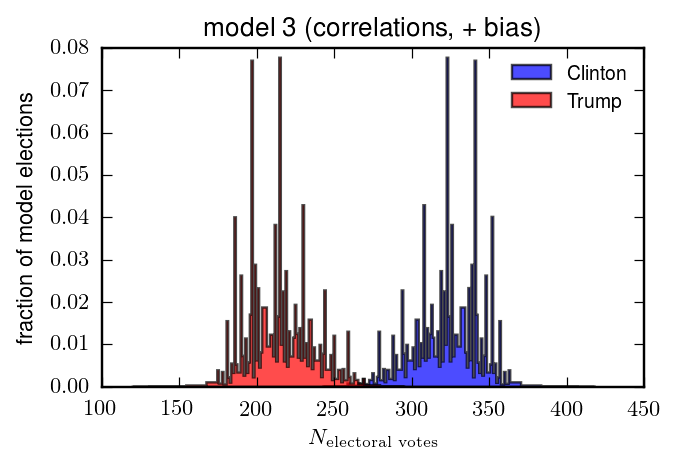

In [238]:
plot_electoral_vote_distribution(model_name, corr_bias_model_results, htype='bayesian_blocks')

============ State-by-state vote predictions for model 3 (correlations, + bias) ==============
               State   Clinton win prob.  Trump win prob.   Johnson win prob.
 
              Alaska        0.260           0.740              0.000
             Alabama        0.006           0.994              0.000
            Arkansas        0.000           1.000              0.000
             Arizona        0.178           0.822              0.000
          California        1.000           0.000              0.000
            Colorado        0.968           0.033              0.000
         Connecticut        0.989           0.011              0.000
District of Columbia        1.000           0.000              0.000
            Delaware        0.959           0.042              0.000
             Florida        0.750           0.250              0.000
             Georgia        0.339           0.661              0.000
              Hawaii        1.000           0.000              0.0

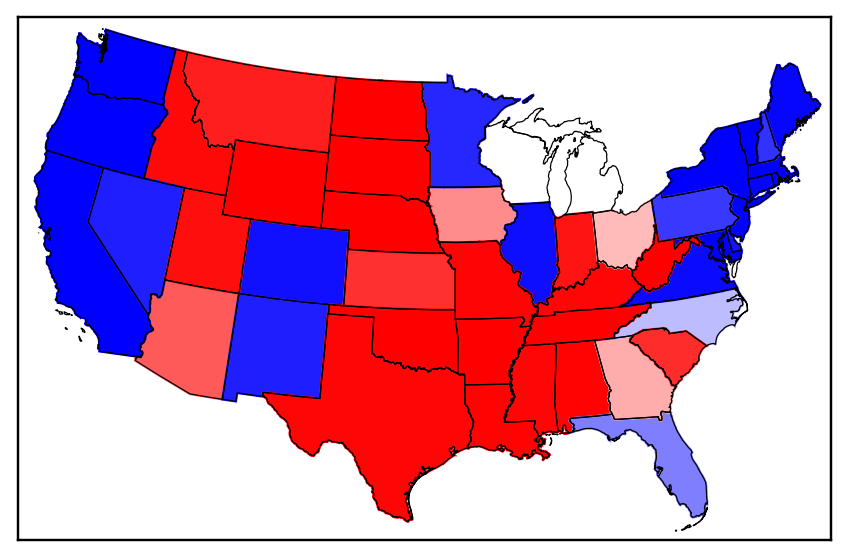

In [239]:
plot_map(model_name, corr_bias_model_results)

#### Model 4 with covariances and poll bias estimated from results and polls of 2008 and 2012 elections (bias reversed)

Previous calculation of the full model shows that bias affects the overall probability of win for Trump by an order of magnitude. It's not clear whether the bias estimate from 2008 and 2012 elections is applicable to the current one. What would happen if bias of similar magnitude would  be applied but with an opposite sign? 

The model calculation below shows this case and shows, strikingly, that in this case Trump would have 44% probability of winning. The bias of the polls relative to the actual result of the magnitude that was seen in previous elections (as well as in the recent Brexit vote, $\sim 5\%$) can qualitatively change model prediction. It is thus the main uncertainty of such predictions and, as far as I can tell, this uncertainty is not accounted for in the probability calculations presented by various sites online. 

In [240]:
nsims = 20000

kwargs = {"bias_dem": -bias_dem, "cov_dem": corr_dem, "bias_rep": -bias_rep, "cov_rep": corr_rep}

corr_revbias_model_results = simulate_elections(poll_data, states_electoral, date_range, poll_type, 
                                   min_weight = 0.5, correlations = True, nsims = nsims, **kwargs)


In [241]:
model_name = r'model 4 (correlations, reversed bias)'
election_stats(model_name, corr_revbias_model_results)

================= Results of election simulations in the  model 4 (correlations, reversed bias) ===
Clinton wins in 49.6 per cent of elections
        average and median Nelectoral = 271.36 and 269.00; in 95 percent range = [222.00  327.00]
Trump   wins in 49.2 per cent of elections
        average and median Nelectoral = 266.64 and 269.00; in 95 percent range = [211.00  316.00]
Johnson wins in 0.0 per cent of elections
        average and median Nelectoral = 0.00 and 0.00; in 95 percent range = [0.00  0.00]


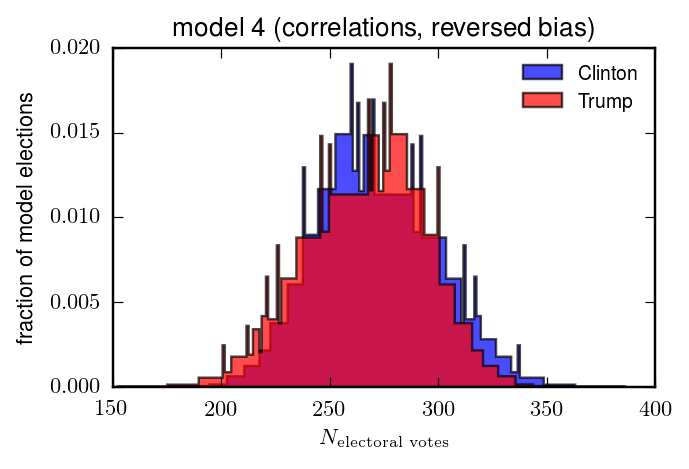

In [242]:
plot_electoral_vote_distribution(model_name, corr_revbias_model_results, htype='bayesian_blocks')

============ State-by-state vote predictions for model 4 (correlations, reversed bias) ==============
               State   Clinton win prob.  Trump win prob.   Johnson win prob.
 
              Alaska        0.303           0.697              0.000
             Alabama        0.017           0.983              0.000
            Arkansas        0.001           0.999              0.000
             Arizona        0.433           0.567              0.000
          California        1.000           0.000              0.000
            Colorado        0.466           0.534              0.000
         Connecticut        0.777           0.223              0.000
District of Columbia        1.000           0.000              0.000
            Delaware        0.929           0.071              0.000
             Florida        0.406           0.594              0.000
             Georgia        0.024           0.976              0.000
              Hawaii        1.000           0.000          

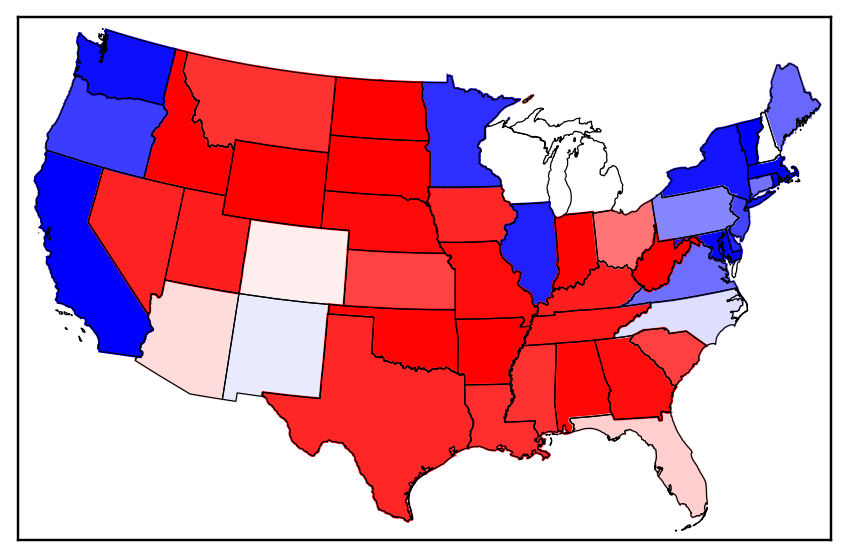

In [243]:
plot_map(model_name, corr_revbias_model_results)

In [244]:
states = states_electoral['Name']

print "============== Average bias of polls measured for states in 2008 and 2012 elections ======="
print "Democrats: %.3f +- %.3f   Republicans: %.3f +- %.3f"%(np.average(bias_dem), np.std(bias_dem), np.average(bias_rep), np.std(bias_rep))
print "============== State-by-state bias of polls measured for states in 2008 and 2012 elections ======"
print "               State      dem bias %      rep bias %"
for i, state in enumerate(states):
    print "%20s        %.3f           %.3f"%(state, bias_dem[i], bias_rep[i])


============== Average bias of polls measured for states in 2008 and 2012 elections =======
Democrats: 4.040 +- 2.256   Republicans: 2.669 +- 2.720
============== State-by-state bias of polls measured for states in 2008 and 2012 elections ======
               State      dem bias %      rep bias %
              Alaska        1.386           1.850
             Alabama        3.376           5.837
            Arkansas        2.775           5.600
             Arizona        3.742           5.181
          California        6.157           1.103
            Colorado        4.306           0.229
         Connecticut        7.022           0.523
District of Columbia        6.950           -3.700
            Delaware        1.500           0.638
             Florida        3.899           2.173
             Georgia        3.998           1.189
              Hawaii        8.450           -3.800
                Iowa        3.862           1.858
               Idaho        5.600           1.500

#### Model 5 with covariances (no bias) estimated from results and polls of 2008 and 2012 elections

This is similar to model 2, but instead of correlation matrix and estimate of standard deviation of current polls this model uses covariance matrix estimated from state-by-state poll results in 2008 and 2012 elections. The difference from model 3 is thus in how uncertainty of the polls is estimated: in model 2 it is estimated from distribution of current poll results, in model 5 it is estimated from the difference of poll results between 2008 and 2012 elections. Otherwise, the correlations between poll fluctuations between states are the same in these two models. No bias is applied, with bias Trump win becomes much more unlikely, as in the model 3 above. 

Overall, the distribution of electoral votes in this model looks closest to the one predicted by <a href="http://projects.fivethirtyeight.com/2016-election-forecast/?ex_cid=rrpromo#electoral-vote">538</a>. Thus, the shape and width of their distribution is largely due to the use of historic correlations between states. The tails of their distributions are much stronger than in any of the models considered here, which explains larger probabilities that Trump is assigned in their results. 

In [245]:
nsims = 20000

kwargs = {"bias_dem": bias_zero, "cov_dem": cov_dem, "bias_rep": bias_zero, "cov_rep": cov_rep}

cov_model_results = simulate_elections(poll_data, states_electoral, date_range, poll_type, 
                                   min_weight = 0.5, correlations = True, nsims = nsims, **kwargs)


In [246]:
model_name = r'model 5 (covariances, no bias)'
election_stats(model_name, cov_model_results)

================= Results of election simulations in the  model 5 (covariances, no bias) ===
Clinton wins in 94.0 per cent of elections
        average and median Nelectoral = 316.33 and 319.00; in 95 percent range = [260.00  367.00]
Trump   wins in 5.3 per cent of elections
        average and median Nelectoral = 221.66 and 219.00; in 95 percent range = [171.00  278.00]
Johnson wins in 0.0 per cent of elections
        average and median Nelectoral = 0.01 and 0.00; in 95 percent range = [0.00  0.00]


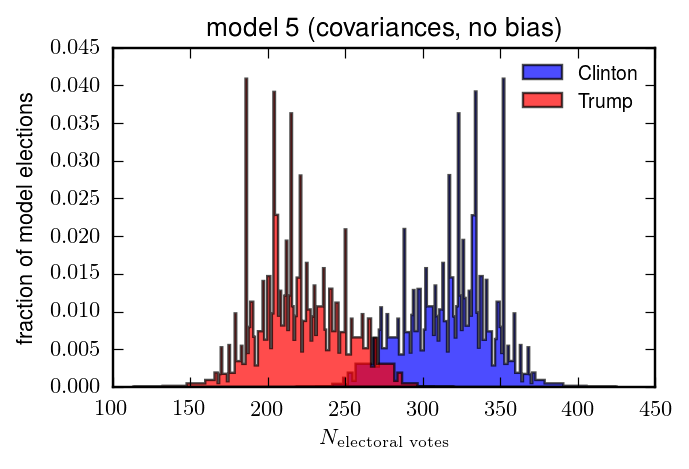

In [247]:
plot_electoral_vote_distribution(model_name, cov_model_results, htype='bayesian_blocks')

============ State-by-state vote predictions for model 5 (covariances, no bias) ==============
               State   Clinton win prob.  Trump win prob.   Johnson win prob.
 
              Alaska        0.366           0.634              0.000
             Alabama        0.011           0.989              0.000
            Arkansas        0.066           0.934              0.000
             Arizona        0.359           0.641              0.000
          California        1.000           0.000              0.000
            Colorado        0.828           0.172              0.000
         Connecticut        0.941           0.059              0.000
District of Columbia        1.000           0.000              0.000
            Delaware        0.845           0.155              0.000
             Florida        0.643           0.357              0.000
             Georgia        0.112           0.888              0.000
              Hawaii        0.997           0.003              0.0

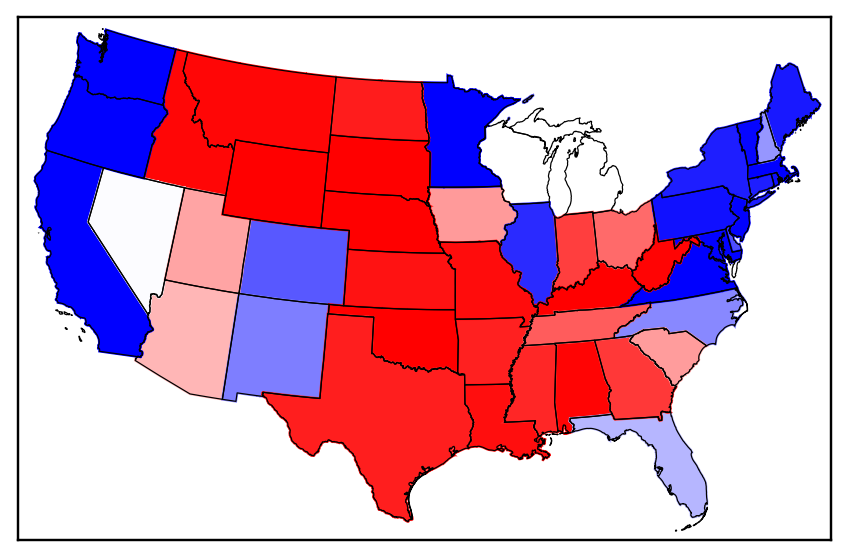

In [248]:
plot_map(model_name, cov_model_results)

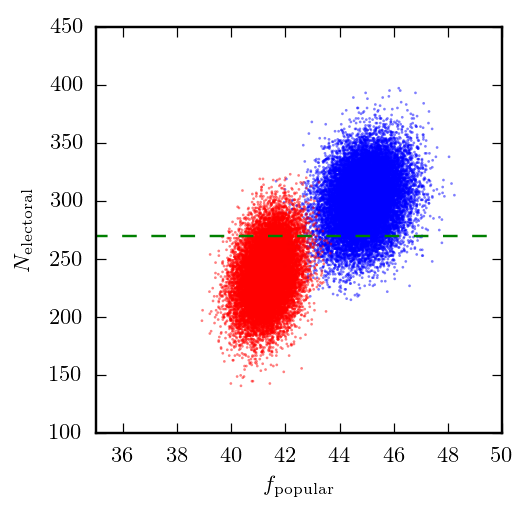

In [159]:
plot_Nelectoral_vs_popular_vote(r'model 1 (simplest model)', 
                                simplest_model_results, states_electoral)

In [158]:
def plot_Nelectoral_vs_popular_vote(model_name, model_results, states_electoral, savefig=None):
    """
    plots of the expected Electoral College votes vs. the fraction of popular vote 
    received for all of the elections
    """
    
    clinton_electoral_votes, trump_electoral_votes, johnson_electoral_votes = model_results[0], model_results[1], model_results[2]
    clinton_vote_dist, trump_vote_dist, johnson_vote_dist = model_results[3], model_results[4], model_results[5]    
    nsims = np.shape(clinton_electoral_votes)[0]
    clinton_pop_vote, trump_pop_vote, johnson_pop_vote = np.zeros(nsims), np.zeros(nsims), np.zeros(nsims)
    
    # compute the popular vote fractions
    states      = states_electoral['State']
    state_names = states_electoral['Name']
    state_pop   = states_electoral['Population']
    total_pop   = np.sum(state_pop)
    nstates     = states.size
    fstate_pop = state_pop / total_pop
    
    for i, state in enumerate(states):
        clinton_pop_vote[:] += clinton_vote_dist[i,:] * fstate_pop[i]
        trump_pop_vote[:]   += trump_vote_dist[i,:]   * fstate_pop[i]
        johnson_pop_vote[:] += johnson_vote_dist[i,:] * fstate_pop[i]
    
    plot_pretty()
    _, ax = plt.subplots(1, 1, figsize=(3,3))
    ax.set_xlim(35., 50.)
    ax.set_xlabel(r'$f_{\rm popular}$'); ax.set_ylabel(r'$N_{\rm electoral}$')
    ax.scatter(clinton_pop_vote, clinton_electoral_votes, marker='.', s=5.0, edgecolor='none', alpha=0.5, c='b')
    ax.scatter(trump_pop_vote, trump_electoral_votes, marker='.', s=5.0, edgecolor='none', alpha=0.5, c='r')
    x = np.arange(0., 100, 0.1); y = 270. * np.ones_like(x)
    ax.plot(x, y, '--', c='g')

In [125]:
%matplotlib inline
from matplotlib import pylab as plt
from codes.plot_utils import plot_pretty

def plot_electoral_vote_distribution(model_name, model_results, 
                                     nbins=60, htype='regular', savefig=None):
    """
    plot histogram of the electoral vote distribution based on model elections
    input:  clinton_electoral_votes, 
            trump_electoral_votes = total counts of electoral votes for Clinton and Trump in model elections
            htype = histogram type: 'regular' or 'bayesian_blocks', 
            nbins = number of bins to use for regular histogram, ignored for bayesian blocks
    """
    
    clinton_electoral_votes, trump_electoral_votes, johnson_electoral_votes = model_results[0], model_results[1], model_results[2]
    clinton_vote_dist, trump_vote_dist, johnson_vote_dist = model_results[3], model_results[4], model_results[5]    
    nsims = np.shape(clinton_electoral_votes)[0]

    plot_pretty()
    _, ax = plt.subplots(1, 1, figsize=(4,2.5))
    ax.set_title(model_name)
    if htype == 'regular':
        ax.set_xlabel(r'$N_{\rm electoral\ votes}$')
        ax.set_ylabel(r'fraction of model elections')
        ax.hist(clinton_electoral_votes, color='b', histtype='stepfilled', alpha=0.7, bins=nbins, 
                label=r'Clinton', normed='True')
        ax.hist(trump_electoral_votes,color='r', histtype='stepfilled', alpha=0.7, bins=nbins, 
                label=r'Trump', normed='True')
        #ax.hist(johnson_electoral_votes,color='g', histtype='stepfilled', alpha=0.7)
        ax.legend(loc='best', frameon=False, fontsize=8)

    elif htype == 'bayesian_blocks': 
        from codes import bayesian_blocks
        bins_clinton = bayesian_blocks.bayesian_blocks(clinton_electoral_votes)
        ax.set_xlabel(r'$N_{\rm electoral\ votes}$')
        ax.set_ylabel(r'fraction of model elections')
        ax.hist(clinton_electoral_votes, bins=bins_clinton, color='b', alpha=0.7, 
                histtype='stepfilled', normed='True', label=r'Clinton')
        bins_trump = bayesian_blocks.bayesian_blocks(trump_electoral_votes)
        ax.hist(trump_electoral_votes, bins=bins_trump, color='r', alpha=0.7, 
                histtype='stepfilled', normed='True', label=r'Trump')
        ax.legend(loc='best', frameon=False, fontsize=8)
    else: 
        print "unknown htype! should be either regular or bayesian_blocks..."
        
    if savefig != None:
        plt.savefig(savefig, bbox_inches='tight')
    plt.show()

In [179]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
import matplotlib.cm as cm
import matplotlib.colors as colors


def plot_map(model_name, model_results):
    clinton_electoral_votes, trump_electoral_votes, johnson_electoral_votes = model_results[0], model_results[1], model_results[2]
    clinton_vote_dist, trump_vote_dist, johnson_vote_dist = model_results[3], model_results[4], model_results[5]
    nsims = np.shape(clinton_electoral_votes)[0]
    
    # create the map
    map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

    # load the shapefile, use the name 'states'
    map.readshapefile(data_home_dir()+'st99_d00', name='states', drawbounds=True)

    # collect the state names from the shapefile attributes so we can
    # look up the shape obect for a state by it's name
    state_names = []
    for shape_dict in map.states_info:
        state_names.append(shape_dict['NAME'])

    ax = plt.gca() # get current axes instance

    cmap = plt.cm.bwr

    states = states_electoral['Name']
    nc = np.zeros(51); colors = np.zeros((51,4))
    print "============ State-by-state vote predictions for %s =============="%model_name
    print "               State   Clinton win prob.  Trump win prob.   Johnson win prob."
    print " "
    for i, ncd in enumerate(nc): 
        clinton_wins = (clinton_vote_dist[i,:] > trump_vote_dist[i,:]) & (clinton_vote_dist[i,:] > johnson_vote_dist[i,:])
        trump_wins   = (trump_vote_dist[i,:]   > clinton_vote_dist[i,:]) & (trump_vote_dist[i,:]>johnson_vote_dist[i,:])
        johnson_wins = (johnson_vote_dist[i,:] > trump_vote_dist[i,:]) & (clinton_vote_dist[i,:] < johnson_vote_dist[i,:])
        vote_ratio_trump   = 1.*len(trump_vote_dist[i,trump_wins]) / nsims
        vote_ratio_clinton = 1.*len(clinton_vote_dist[i,clinton_wins]) / nsims
        vote_ratio_johnson = 1.*len(johnson_vote_dist[i,johnson_wins]) / nsims
        print "%20s        %.3f           %.3f              %.3f"%(states[i], vote_ratio_clinton, vote_ratio_trump, vote_ratio_johnson)
        colors[i] = cmap(vote_ratio_trump)

    for i, state in enumerate(states):
        # get state and draw the filled polygon
        seg = map.states[state_names.index(state)]
        poly = Polygon(seg, facecolor=colors[i], edgecolor=colors[i])
        ax.add_patch(poly)

    plt.show()

In [174]:
def election_stats(model_name, model_results):
    
    clinton_electoral_votes, trump_electoral_votes, johnson_electoral_votes = model_results[0], model_results[1], model_results[2]
    clinton_vote_dist, trump_vote_dist, johnson_vote_dist = model_results[3], model_results[4], model_results[5]    
    nsims = np.shape(clinton_electoral_votes)[0]
    
    print "================= Results of election simulations in the ", model_name,"==="

    trump_wins   = (trump_electoral_votes > clinton_electoral_votes) & (trump_electoral_votes > johnson_electoral_votes)
    clinton_wins = (trump_electoral_votes < clinton_electoral_votes) & (johnson_electoral_votes < clinton_electoral_votes)
    johnson_wins = (trump_electoral_votes < johnson_electoral_votes) & (johnson_electoral_votes > clinton_electoral_votes)

    fclinton_wins = 1.*len(clinton_electoral_votes[clinton_wins]) / nsims
    ftrump_wins   = 1.*len(trump_electoral_votes[trump_wins]) / nsims
    fjohnson_wins = 1.*len(johnson_electoral_votes[johnson_wins]) / nsims

    print "Clinton wins in %.1f per cent of elections"%(fclinton_wins*100.)
    print "        average and median Nelectoral = %.2f and %.2f; in 95 percent range = [%.2f  %.2f]"%(
        np.mean(clinton_electoral_votes), np.median(clinton_electoral_votes), 
        np.percentile(clinton_electoral_votes,2.5), np.percentile(clinton_electoral_votes,97.5))
    print "Trump   wins in %.1f per cent of elections"%(ftrump_wins*100.)
    print "        average and median Nelectoral = %.2f and %.2f; in 95 percent range = [%.2f  %.2f]"%(
        np.mean(trump_electoral_votes), np.median(trump_electoral_votes), 
        np.percentile(trump_electoral_votes,2.5), np.percentile(trump_electoral_votes,97.5))

    print "Johnson wins in %.1f per cent of elections"%(fjohnson_wins*100.)
    print "        average and median Nelectoral = %.2f and %.2f; in 95 percent range = [%.2f  %.2f]"%(
        np.mean(johnson_electoral_votes), np.median(johnson_electoral_votes), 
        np.percentile(johnson_electoral_votes,2.5), np.percentile(johnson_electoral_votes,97.5))
    